<a href="https://colab.research.google.com/github/ozzafar/ozzafar-Discriminative-Class-Tokens-for-Counting-Notebook/blob/main/discrimnative_tokens_for_counting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Setup (may take a few minutes)
!git clone https://github.com/ozzafar/discriminative_class_tokens_for_counting
import os
os.chdir(f'./discriminative_class_tokens_for_counting')
os.sys.path.append('./discriminative_class_tokens_for_counting')



!pip install accelerate
!pip install diffusers
!pip install transformers
!pip install kornia==0.6.11
!pip install pyrallis==0.3.1



import torch

import os
from pathlib import Path
import torch.utils.checkpoint
import itertools
from accelerate import Accelerator
from diffusers import StableDiffusionPipeline
import prompt_dataset
import utils
from inet_classes import IDX2NAME as IDX2NAME_INET

import shutil
#from pydrive.auth import GoogleAuth
#from pydrive.drive import GoogleDrive
#from google.colab import auth
#from oauth2client.client import GoogleCredentials
#Authenticate and create the PyDrive client.
#auth.authenticate_user()
#gauth = GoogleAuth()
#gauth.credentials = GoogleCredentials.get_application_default()
#drive = GoogleDrive(gauth)

import pdb

fatal: destination path 'discriminative_class_tokens_for_counting' already exists and is not an empty directory.


# Hyperparameters

In [2]:
class_index: int = 283 #@param {type:"number"}

sd_2_1: bool = False #@param {type:"boolean"}

classifier: str = 'clip' #@param ['inet', 'inat', 'cub','clip','clip-count'] {type:"string"}

# Affect training time
early_stopping: int = 15 #@param {type:"integer"}
num_train_epochs: int = 50 #@param {type:"integer"}

# affect variability of the training images
# i.e., also sets batch size with accumulation
epoch_size: int = 5 #@param {type:"integer"}
number_of_prompts: int = 3 #@param {type:"integer"}
batch_size: int = 1 #@param {type:"integer"}
gradient_accumulation_steps: int = 5 #@param {type:"integer"}

# Skip if there exists a token checkpoint
skip_exists: bool = False #@param {type:"boolean"}

# Train and Optimization
lr: float = 0.00125 #@param {type:"number"}
betas1: tuple = 0.9 #@param {type:"number"}
betas2: tuple = 0.999 #@param {type:"number"}
betas = (betas1, betas2)


weight_decay: float = 1e-2 #@param {type:"number"}
eps: float = 1e-08 #@param {type:"number"}
max_grad_norm: str = "1" #@param {type:"string"}
seed: int = 35 #@param {type:"integer"}

# Generative model
guidance_scale: int = 7 #@param {type:"integer"}
height: int = 512 #@param {type:"integer"}
width: int = 512 #@param {type:"integer"}
num_of_SD_inference_steps: int = 35 #@param {type:"integer"}

# Discriminative tokens
placeholder_token: str = "newclas" #@param {type:"string"}
initializer_token: str = "a" #@param {type:"string"}

# Path to save all outputs to
output_path: str = "results" #@param {type:"string"}
save_as_full_pipeline: bool = True #@param {type:"boolean"}

# Cuda related
device: str = "cuda" #@param {type:"string"}
mixed_precision: str = "fp16" #@param ["fp16", "fp32"] {type:"string"}
gradient_checkpointing: bool = True #@param {type:"boolean"}

# evaluate
test_size: int = 10 #@param {type:"integer"}

In [3]:
from collections import namedtuple
# Define the configuration names
config_names = [
    "class_index",
    "sd_2_1",
    "classifier",
    "early_stopping",
    "num_train_epochs",
    "epoch_size",
    "number_of_prompts",
    "batch_size",
    "gradient_accumulation_steps",
    "skip_exists",
    "betas",
    "lr",
    "eps",
    "weight_decay",
    "seed",
    "max_grad_norm",
    "guidance_scale",
    "height",
    "width",
    "num_of_SD_inference_steps",
    "placeholder_token",
    "initializer_token",
    "output_path",
    "save_as_full_pipeline",
    "device",
    "mixed_precision",
    "gradient_checkpointing",
    "test_size"
]

# Use globals() to extract values from matching variable names
config_values = [globals()[name] for name in config_names]

# Create the named tuple
Config = namedtuple("Config", config_names)
config = Config(*config_values)
config

Config(class_index=283, sd_2_1=False, classifier='clip', early_stopping=15, num_train_epochs=50, epoch_size=5, number_of_prompts=3, batch_size=1, gradient_accumulation_steps=5, skip_exists=False, betas=(0.9, 0.999), lr=0.00125, eps=1e-08, weight_decay=0.01, seed=35, max_grad_norm='1', guidance_scale=7, height=512, width=512, num_of_SD_inference_steps=35, placeholder_token='newclas', initializer_token='a', output_path='results', save_as_full_pipeline=True, device='cuda', mixed_precision='fp16', gradient_checkpointing=True, test_size=10)

# Train

In [4]:
import importlib
importlib.reload(utils)

<module 'utils' from '/content/discriminative_class_tokens_for_counting/utils.py'>

Start experiment 1.4_5_0.00125_35_3_15
Start training class token for a photo of five cats


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


Epoch 0
On epoch 0 
['a high resolution realistic image of newclas a photo of five cats'] 
Loss: 1.4199187755584717


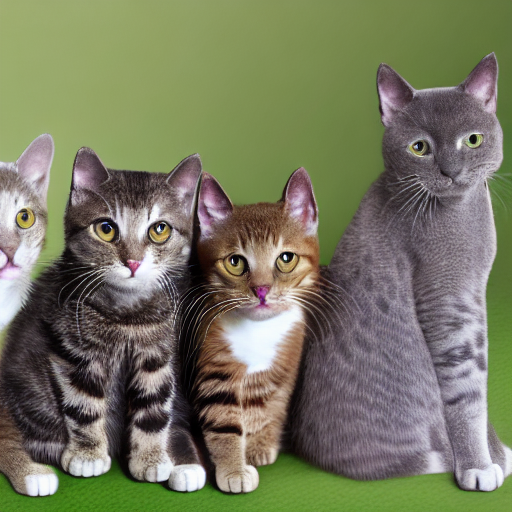

> <ipython-input-6-9e6336fb5f7a>(322)<cell line: 166>()
    320             # Zero out the gradients for all token embeddings except the newly added
    321             # embeddings for the concept, as we only want to optimize the concept embeddings
--> 322             if accelerator.num_processes > 1:
    323                 grads = (
    324                     text_encoder.module.get_input_embeddings().weight.grad

ipdb> accelerator.num_processes
1
ipdb> text_encoder.get_input_embeddings().weight.grad
ipdb>  text_encoder.get_input_embeddings()
Embedding(49409, 768)
ipdb> text_encoder.get_input_embeddings().weight
Parameter containing:
tensor([[-0.0012,  0.0368,  0.0221,  ...,  0.0158,  0.0046, -0.0219],
        [ 0.0152,  0.0262, -0.0132,  ..., -0.0037,  0.0002,  0.0121],
        [-0.0154, -0.0131,  0.0065,  ..., -0.0206, -0.0139, -0.0025],
        ...,
        [ 0.0011,  0.0032,  0.0003,  ..., -0.0018,  0.0003,  0.0019],
        [ 0.0012,  0.0077, -0.0011,  ..., -0.0015,  0.0009,  


PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/lib/python3.10/bdb.py", line 361, in set_quit
    sys.settrace(None)


PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/debugger.py", line 1075, in cmdloop
    sys.settrace(None)



--KeyboardInterrupt--

KeyboardInterrupt: Interrupted by user


AttributeError: 'NoneType' object has no attribute 'data'

In [6]:
from transformers import CLIPProcessor

# Classification model
classification_model = utils.prepare_classifier(config)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")


exp_identifier = (
    f'{"2.1" if config.sd_2_1 else "1.4"}_{config.epoch_size}_{config.lr}_'
    f"{config.seed}_{config.number_of_prompts}_{config.early_stopping}"
)

if config.classifier == "inet":
    IDX2NAME = IDX2NAME_INET
else:
    IDX2NAME = classification_model.config.id2label

#### Train ####
print(f"Start experiment {exp_identifier}")

class_name = "a photo of five cats"
print(f"Start training class token for {class_name}")
img_dir_path = f"img/{class_name}/train"
if Path(img_dir_path).exists():
    shutil.rmtree(img_dir_path)
Path(img_dir_path).mkdir(parents=True, exist_ok=True)

# Stable model
unet, vae, text_encoder, scheduler, tokenizer = utils.prepare_stable(config)

#  Extend tokenizer and add a discriminative token ###
class_infer = 1
prompt_suffix = " ".join(class_name.lower().split("_"))

## Add the placeholder token in tokenizer
num_added_tokens = tokenizer.add_tokens(config.placeholder_token)
if num_added_tokens == 0:
    raise ValueError(
        f"The tokenizer already contains the token {config.placeholder_token}. Please pass a different"
        " `placeholder_token` that is not already in the tokenizer."
    )

## Get token ids for our placeholder and initializer token.
# This code block will complain if initializer string is not a single token
## Convert the initializer_token, placeholder_token to ids
token_ids = tokenizer.encode(config.initializer_token, add_special_tokens=False)
# Check if initializer_token is a single token or a sequence of tokens
if len(token_ids) > 1:
    raise ValueError("The initializer token must be a single token.")

initializer_token_id = token_ids[0]
placeholder_token_id = tokenizer.convert_tokens_to_ids(config.placeholder_token)

# we resize the token embeddings here to account for placeholder_token
text_encoder.resize_token_embeddings(len(tokenizer))

#  Initialise the newly added placeholder token
token_embeds = text_encoder.get_input_embeddings().weight.data
token_embeds[placeholder_token_id] = token_embeds[initializer_token_id]

# Define dataloades

def collate_fn(examples):
    input_ids = [example["instance_prompt_ids"] for example in examples]
    input_ids = tokenizer.pad(
        {"input_ids": input_ids}, padding=True, return_tensors="pt"
    ).input_ids
    texts = [example["instance_prompt"] for example in examples]
    batch = {
        "texts": texts,
        "input_ids": input_ids,
    }

    return batch

train_dataset = prompt_dataset.PromptDataset(
    prompt_suffix=prompt_suffix,
    tokenizer=tokenizer,
    placeholder_token=config.placeholder_token,
    number_of_prompts=config.number_of_prompts,
    epoch_size=config.epoch_size,
)

train_batch_size = config.batch_size
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    pin_memory=True,
)

# Define optimization

## Freeze vae and unet
utils.freeze_params(vae.parameters())
utils.freeze_params(unet.parameters())

## Freeze all parameters except for the token embeddings in text encoder
params_to_freeze = itertools.chain(
    text_encoder.text_model.encoder.parameters(),
    text_encoder.text_model.final_layer_norm.parameters(),
    text_encoder.text_model.embeddings.position_embedding.parameters(),
)
utils.freeze_params(params_to_freeze)

optimizer_class = torch.optim.AdamW
optimizer = optimizer_class(
    text_encoder.get_input_embeddings().parameters(),  # only optimize the embeddings
    lr=config.lr,
    betas=config.betas,
    weight_decay=config.weight_decay,
    eps=config.eps,
)
criterion = torch.nn.BCELoss().cuda()

accelerator = Accelerator(
    gradient_accumulation_steps=config.gradient_accumulation_steps,
    mixed_precision=config.mixed_precision,
)

if config.gradient_checkpointing:
    text_encoder.gradient_checkpointing_enable()
    unet.enable_gradient_checkpointing()

text_encoder, optimizer, train_dataloader = accelerator.prepare(
    text_encoder, optimizer, train_dataloader
)

weight_dtype = torch.float32
if accelerator.mixed_precision == "fp16":
    weight_dtype = torch.float16
elif accelerator.mixed_precision == "bf16":
    weight_dtype = torch.bfloat16

# Move vae and unet to device
vae.to(accelerator.device, dtype=weight_dtype)
unet.to(accelerator.device, dtype=weight_dtype)

classification_model = classification_model.to(accelerator.device)
text_encoder = text_encoder.to(accelerator.device)

# Keep vae in eval mode as we don't train it
vae.eval()
# Keep unet in train mode to enable gradient checkpointing
unet.train()

global_step = 0
total_loss = 0
min_loss = 99999

# Define token output dir
token_dir_path = f"token/{class_name}"
Path(token_dir_path).mkdir(parents=True, exist_ok=True)
token_path = f"{token_dir_path}/{exp_identifier}_{class_name}"

latents_shape = (
    config.batch_size,
    unet.config.in_channels,
    config.height // 8,
    config.width // 8,
)


#### Training loop ####
for epoch in range(config.num_train_epochs):
    print(f"Epoch {epoch}")
    generator = torch.Generator(
        device=config.device
    )  # Seed generator to create the inital latent noise
    generator.manual_seed(config.seed)
    correct = 0
    for step, batch in enumerate(train_dataloader):
        # setting the generator here means we update the same images
        classification_loss = None
        with accelerator.accumulate(text_encoder):
            # Get the text embedding for conditioning
            encoder_hidden_states = text_encoder(batch["input_ids"])[0]

            # here `guidance_scale` is defined analog to the guidance weight `w` of equation (2)
            # of the Imagen paper: https://arxiv.org/pdf/2205.11487.pdf . `guidance_scale = 1`
            # corresponds to doing no classifier free guidance.
            do_classifier_free_guidance = config.guidance_scale > 1.0

            # get unconditional embeddings for classifier free guidance
            if do_classifier_free_guidance:
                max_length = batch["input_ids"].shape[-1]
                uncond_input = tokenizer(
                    [""] * config.batch_size,
                    padding="max_length",
                    max_length=max_length,
                    return_tensors="pt",
                )
                uncond_embeddings = text_encoder(
                    uncond_input.input_ids.to(config.device)
                )[0]

                # For classifier free guidance, we need to do two forward passes.
                # Here we concatenate the unconditional and text embeddings into
                # a single batch to avoid doing two forward passes.
                encoder_hidden_states = torch.cat(
                    [uncond_embeddings, encoder_hidden_states]
                )
            encoder_hidden_states = encoder_hidden_states.to(
                dtype=weight_dtype
            )
            init_latent = torch.randn(
                latents_shape, generator=generator, device="cuda"
            ).to(dtype=weight_dtype)

            latents = init_latent
            scheduler.set_timesteps(config.num_of_SD_inference_steps)
            grad_update_step = config.num_of_SD_inference_steps - 1

            # generate image
            for i, t in enumerate(scheduler.timesteps):
                if i < grad_update_step:  # update only partial
                    with torch.no_grad():
                        latent_model_input = (
                            torch.cat([latents] * 2)
                            if do_classifier_free_guidance
                            else latents
                        )
                        noise_pred = unet(
                            latent_model_input,
                            t,
                            encoder_hidden_states=encoder_hidden_states,
                        ).sample

                        # perform guidance
                        if do_classifier_free_guidance:
                            (
                                noise_pred_uncond,
                                noise_pred_text,
                            ) = noise_pred.chunk(2)
                            noise_pred = (
                                noise_pred_uncond
                                + config.guidance_scale
                                * (noise_pred_text - noise_pred_uncond)
                            )

                        latents = scheduler.step(
                            noise_pred, t, latents
                        ).prev_sample
                else:
                    latent_model_input = (
                        torch.cat([latents] * 2)
                        if do_classifier_free_guidance
                        else latents
                    )
                    noise_pred = unet(
                        latent_model_input,
                        t,
                        encoder_hidden_states=encoder_hidden_states,
                    ).sample
                    # perform guidance
                    if do_classifier_free_guidance:
                        (
                            noise_pred_uncond,
                            noise_pred_text,
                        ) = noise_pred.chunk(2)
                        noise_pred = (
                            noise_pred_uncond
                            + config.guidance_scale
                            * (noise_pred_text - noise_pred_uncond)
                        )

                    latents = scheduler.step(
                        noise_pred, t, latents
                    ).prev_sample
                    # scale and decode the image latents with vae

            latents_decode = 1 / 0.18215 * latents
            image = vae.decode(latents_decode).sample
            image = (image / 2 + 0.5).clamp(0, 1)

            image_out = image

            # image = utils.transform_img_tensor(image, config)

            inputs = processor(text=[class_name], images=image_out, return_tensors="pt", padding=True).to(device)
            # output = classification_model(**inputs)[0][0]
            output = (classification_model(**inputs)[0][0]/100).cuda()


            if classification_loss is None:
                classification_loss = criterion(
                    output, torch.FloatTensor([class_infer]).cuda()
                )
            else:
                classification_loss += criterion(
                    output, torch.FloatTensor([class_infer]).cuda()
                )

            total_loss += classification_loss.detach().item()

            # log
            txt = f"On epoch {epoch} \n"
            with torch.no_grad():
                txt += f"{batch['texts']} \n"
                txt += f"Loss: {classification_loss.detach().item()}"
                with open("run_log.txt", "a") as f:
                    print(txt, file=f)
                print(txt)
                display(utils.numpy_to_pil(
                    image_out.permute(0, 2, 3, 1).cpu().detach().numpy()
                )[0])

            torch.nn.utils.clip_grad_norm_(
                text_encoder.get_input_embeddings().parameters(),
                config.max_grad_norm,
            )

            accelerator.backward(classification_loss)


            pdb.set_trace()

            # Zero out the gradients for all token embeddings except the newly added
            # embeddings for the concept, as we only want to optimize the concept embeddings
            if accelerator.num_processes > 1:
                grads = (
                    text_encoder.module.get_input_embeddings().weight.grad
                )
            else:
                grads = text_encoder.get_input_embeddings().weight.grad

            # Get the index for tokens that we want to zero the grads for
            index_grads_to_zero = (
                torch.arange(len(tokenizer)) != placeholder_token_id
            )
            grads.data[index_grads_to_zero, :] = grads.data[
                index_grads_to_zero, :
            ].fill_(0)

            optimizer.step()
            optimizer.zero_grad()

            # Checks if the accelerator has performed an optimization step behind the scenes
            if accelerator.sync_gradients:
                if total_loss > 2 * min_loss:
                    print("!!!!training collapse, try different hp!!!!")
                    epoch = config.num_train_epochs
                    break
                print("update")
                if total_loss < min_loss:
                    min_loss = total_loss
                    current_early_stopping = config.early_stopping
                    # Create the pipeline using the trained modules and save it.
                    accelerator.wait_for_everyone()
                    if accelerator.is_main_process:
                        print(
                            f"Saved the new discriminative class token pipeline of {class_name} to pipeline_{token_path}"
                        )
                        if config.sd_2_1:
                            pretrained_model_name_or_path = (
                                "stabilityai/stable-diffusion-2-1-base"
                            )
                        else:
                            pretrained_model_name_or_path = (
                                "CompVis/stable-diffusion-v1-4"
                            )
                        pipeline = StableDiffusionPipeline.from_pretrained(
                            pretrained_model_name_or_path,
                            text_encoder=accelerator.unwrap_model(
                                text_encoder
                            ),
                            vae=vae,
                            unet=unet,
                            tokenizer=tokenizer,
                        )
                        pipeline.save_pretrained(f"pipeline_{token_path}")
                else:
                    current_early_stopping -= 1
                print(
                    f"{current_early_stopping} steps to stop, current best {min_loss}"
                )

                total_loss = 0
                global_step += 1
    print(f"Current accuracy {correct / config.epoch_size}")

    if (correct / config.epoch_size > 0.7) or current_early_stopping < 0:
        break

# Eval

In [ ]:
print("Evaluation - print image with discriminatory tokens, then one without.")
# Stable model
token_dir_path = f"token/{class_name}"
Path(token_dir_path).mkdir(parents=True, exist_ok=True)
pipe_path = f"pipeline_{token_dir_path}/{exp_identifier}_{class_name}"
pipe = StableDiffusionPipeline.from_pretrained(pipe_path).to(config.device)

class_index = config.class_index - 1

correct = dict()
correct['a'] = 0
correct[config.placeholder_token] = 0

for seed in range(config.test_size):
    generator = torch.Generator(device=config.device)  # Seed generator to create the inital latent noise
    generator.manual_seed(seed)

    for descriptive_token in [config.placeholder_token, "a"]:
      prompt = f"A photo of {descriptive_token} {prompt_suffix}"
      print(f"Evaluation for the prompt: {prompt}")

      image_out = pipe(prompt, output_type='pt', generator=generator)[0]
      image = utils.transform_img_tensor(image_out, config)

      output = classification_model(image).logits
      pred_class = torch.argmax(output).item()

      display(utils.numpy_to_pil(image_out.permute(0, 2, 3, 1).cpu().detach().numpy())[0])

      if pred_class == class_index:
          correct[descriptive_token] += 1
      print(f"Image class: {IDX2NAME[pred_class]}")
for descriptive_token in [config.placeholder_token, ""]:

  acc = correct[descriptive_token] / config.test_size
  print(f"-----------------------Accuracy {descriptive_token} {acc}-----------------------------")